<a href="https://colab.research.google.com/github/EliasEconomou/AI2-Natural-Language-Processing/blob/main/Natural_Language_Processing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Reading Datafile**

In [1]:
import numpy as np
import pandas as pd
import sys
import os.path
import time

import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

from itertools import chain
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
# Read data files
def read_csv_file(filePath,separator):
  fileExists = os.path.exists(filePath)
  if fileExists:
    rFile = pd.read_csv(filePath,sep=separator)
  else:
    print('Enter data file path:')
    filePath = input()
    rFile = pd.read_csv(filePath,sep=separator)
  return rFile

In [3]:
# Reading data file
filePath = "./drive/MyDrive/ColabNotebooks/Homework_2/imdb-reviews.csv"
initDF = read_csv_file(filePath,'\t')
initDF.head()

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


# **Preprocessing Functions**
> Let's create some functions to help us clean and prepare a dataset with the above format for training/evaluating.

In [4]:
def preprocess_dataframe(df):
  toBeCleanDF = df

  # Let's remove any missing values
  toBeCleanDF.dropna(inplace = True)

  # We 're probably going to skip using the url column
  toBeCleanDF = toBeCleanDF.drop(["url"], axis=1)

  # Change the column order for simplicity
  toBeCleanDF = toBeCleanDF[["review","rating"]]

  # Remove punctuation, links, hashtags, new lines etc, using regular expressions
  toBeCleanDF["review"] = toBeCleanDF["review"].replace('\"|\'|\.|,|\?|!|:|\(|\)|%|\$|;','', regex=True)
  toBeCleanDF["review"] = toBeCleanDF["review"].replace('\n|\t','', regex=True)
  toBeCleanDF["review"] = toBeCleanDF["review"].replace(r'(http\S+)|(www\S+)|(#\S+)|(&\S+)|(@\S+)','', regex=True)
  toBeCleanDF["review"] = toBeCleanDF["review"].replace('(\s-\s)','', regex=True)
  toBeCleanDF["review"] = toBeCleanDF["review"].replace(r'\b[0-9]+\b', '', regex=True)
  toBeCleanDF["review"] = toBeCleanDF["review"].replace("<br />", ' ', regex=True)
  toBeCleanDF["review"] = toBeCleanDF["review"].replace('/','', regex=True)

  # Remove emojis by encoding - decoding into ascii, resulting in ignoring them
  toBeCleanDF["review"] = toBeCleanDF["review"].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

  # Convert review to lowercase
  toBeCleanDF["review"] = toBeCleanDF["review"].str.lower()
  
  # We'll create a list of stopwords to remove, like 'i','is','you', etc
  stopWords = list(stopwords.words('english'))
  # Maybe remove or add some more words
  stopWords.remove("why")
  stopWords.remove("how")
  stopWords.remove("against")
  stopWords.remove("again")
  stopWords.remove("not")
  stopWords.append("'ve")
  stopWords.append("'re")
  stopWords.append("'s")
  stopWords.append("``")
  stopWords.append("''")

  # Let's also create a new column named evaluation to categorize reviews into positive, negative
  # based on their rating (1-4 : negative as 'NEG' - 7-10 : positive as 'POS')
  rating_ranges = [ (toBeCleanDF["rating"] <= 4), (toBeCleanDF["rating"] >=7) ]
  sentiment = ["NEG", "POS"]

  toBeCleanDF['sentiment'] = np.select(rating_ranges, sentiment)
  
  return toBeCleanDF,stopWords

In [5]:
# Tokenize the reviews
def tokenize_dataframe(df,stopWords):
  toBeTokenisedDF = df

  toBeTokenisedDF["review"] = toBeTokenisedDF["review"].apply(word_tokenize)
  toBeTokenisedDF["review"] = toBeTokenisedDF["review"].apply(lambda words: [word for word in words if word not in stopWords])

  # Remove any unnecessary spaces that came up
  toBeTokenisedDF["review"] = toBeTokenisedDF["review"].replace(' +', ' ', regex=True)

  return toBeTokenisedDF

In [6]:
def lemmatize_words(words):
  lemmatizer = WordNetLemmatizer()
  # We'll lemmatize nouns and verbs
  words = [lemmatizer.lemmatize(noun, "n") for noun in words]
  words = [lemmatizer.lemmatize(verb, "v") for verb in words]
  
  return words

In [7]:
# Lemmatize the reviews
def lemmatize_dataframe(df):
  toBeLemmatisedDF = df.assign(review = df.review.apply(lambda x: lemmatize_words(x)))

  return toBeLemmatisedDF

# **Preprocessing and Cleaning Data**
> We start by cleaning the given dataset of missing values, stop words, links, emojis etc then tokenizing and lemmatizing the data.

In [8]:
cleanedDF,StopWords = preprocess_dataframe(initDF)
cleanedDF = pd.DataFrame(cleanedDF)
cleanedDF.head()

,review,rating,sentiment
0,i thought this was a quiet good movie it was f...,10.0,POS
1,wagon master is a very unique film amongst joh...,9.0,POS
2,this film has to be as near to perfect a film ...,10.0,POS
3,i gave this stars because it has a lot of int...,4.0,NEG
4,this movie is really genuine and random its re...,10.0,POS


In [9]:
tokenisedDF = tokenize_dataframe(cleanedDF,StopWords)
tokenisedDF = pd.DataFrame(tokenisedDF)
tokenisedDF.head()

,review,rating,sentiment
0,"[thought, quiet, good, movie, fun, watch, like...",10.0,POS
1,"[wagon, master, unique, film, amongst, john, f...",9.0,POS
2,"[film, near, perfect, film, john, ford, made, ...",10.0,POS
3,"[gave, stars, lot, interesting, themes, many, ...",4.0,NEG
4,"[movie, really, genuine, random, really, hard,...",10.0,POS


In [10]:
lemmatisedDF = lemmatize_dataframe(tokenisedDF)
lemmatisedDF = pd.DataFrame(lemmatisedDF)
lemmatisedDF.head()

,review,rating,sentiment
0,"[think, quiet, good, movie, fun, watch, like, ...",10.0,POS
1,"[wagon, master, unique, film, amongst, john, f...",9.0,POS
2,"[film, near, perfect, film, john, ford, make, ...",10.0,POS
3,"[give, star, lot, interest, theme, many, alrea...",4.0,NEG
4,"[movie, really, genuine, random, really, hard,...",10.0,POS


In [11]:
# Let's convert sentiments to numbers for later use
lemmatisedDF['sentiment'] = lemmatisedDF['sentiment'].replace(['NEG','POS'],[0,1])
lemmatisedDF.head()

,review,rating,sentiment
0,"[think, quiet, good, movie, fun, watch, like, ...",10.0,1
1,"[wagon, master, unique, film, amongst, john, f...",9.0,1
2,"[film, near, perfect, film, john, ford, make, ...",10.0,1
3,"[give, star, lot, interest, theme, many, alrea...",4.0,0
4,"[movie, really, genuine, random, really, hard,...",10.0,1


# **Analyzing Data (optional)**


> Let's do some basic analysis to extract usefull information about our reviews.



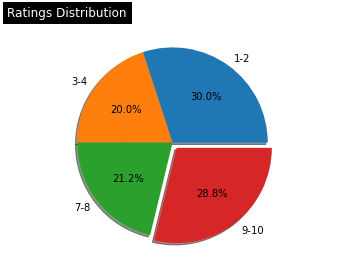

In [ ]:
ratingsDICT = {'1-2' : 0, '3-4' : 0, '7-8' : 0, '9-10' : 0}
for rating in lemmatisedDF["rating"]:
  if rating == 1.0 or rating == 2.0:
    ratingsDICT["1-2"] += 1
  elif rating == 3.0 or rating == 4.0:
    ratingsDICT["3-4"] += 1
  elif rating == 7.0 or rating == 8.0:
    ratingsDICT["7-8"] += 1
  elif rating == 9.0 or rating == 10.0:
    ratingsDICT["9-10"] += 1

labels = ratingsDICT.keys()
sizes = ratingsDICT.values()
explode = [0, 0, 0, 0.07]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')
plt.title(label="Ratings Distribution",
          loc="left",
          pad='20.0',
          backgroundcolor='black',
          color='white')
plt.show()

We see that there are almost equally numbered negative/positive reviews.

In [ ]:
# Group by sentiment and plot wordclouds for most used words in every sentiment
groupBySent = lemmatisedDF.groupby('sentiment')

POSgroup = groupBySent.get_group('POS')
NEGgroup = groupBySent.get_group('NEG')

In [ ]:
POSList = list(chain.from_iterable(list(POSgroup["review"])))
POSfdist = FreqDist(POSList)
NEGList = list(chain.from_iterable(list(NEGgroup["review"])))
NEGfdist = FreqDist(NEGList)

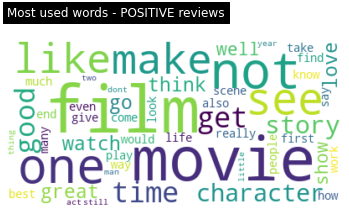

In [ ]:
POScloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(POSfdist)

plt.imshow(POScloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words - POSITIVE reviews',
          loc="left",
          pad='25.0',
          backgroundcolor='black',
          color='white')
plt.show()

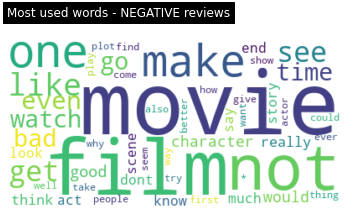

In [ ]:
NEGcloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(NEGfdist)

plt.imshow(NEGcloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words - NEGATIVE reviews',
          loc="left",
          pad='25.0',
          backgroundcolor='black',
          color='white')
plt.show()

# **Split data into train/validation sets**

In [12]:
DF = lemmatisedDF

# Keep data in X and labels in y
X, y = DF.drop(columns = ["sentiment","rating"]), DF.drop(columns = ["review","rating"])
print(X.shape, y.shape)

(45008, 1) (45008, 1)


In [13]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33756, 1) (11252, 1) (33756, 1) (11252, 1)


# **Use a test set (optional)**


> Here we can use a different test set to test our model.

In [ ]:
# Reading test file
testPath = " "
testDF = read_csv_file(testPath,'\t')
testDF.head()

In [ ]:
cleanedTestDF,StopWords = preprocess_dataframe(testDF)
cleanedTestDF = pd.DataFrame(cleanedTestDF)
cleanedTestDF.head()

In [ ]:
tokenisedTestDF = tokenize_dataframe(cleanedTestDF,StopWords)
tokenisedTestDF = pd.DataFrame(tokenisedTestDF)
tokenisedTestDF.head()

In [ ]:
lemmatisedTestDF = lemmatize_dataframe(tokenisedTestDF)
lemmatisedTestDF = pd.DataFrame(lemmatisedTestDF)
lemmatisedTestDF.head()

In [ ]:
X_test, y_test = lemmatisedTestDF.drop(columns = ["sentiment","rating"]), lemmatisedTestDF.drop(columns = ["review","rating"])
print(X_test.shape, y_test.shape)

(3167, 1) (3167, 1)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=2000)

# Create TF-IDF for train data
tfidf_X_train = tfidf_vectorizer.fit_transform(X_train["review"].astype(str))

# Create TF-IDF for test data
tfidf_X_test = tfidf_vectorizer.transform(X_test["review"].astype(str))

# print(tfidf_vectorizer.vocabulary_)

# **Download Glove Embeddings**


In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-12-11 16:56:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-11 16:56:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-11 16:56:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [14]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [15]:
glove6B_txt_path = 'glove.6B.200d.txt'

# **Or Load Glove Embeddings from Drive (Optional)**


> An option to load the embeddings if downloading them takes a lot of time.

In [14]:
glove6B_txt_path = '/content/drive/MyDrive/ColabNotebooks/Homework_2/glove.6B.200d.txt'

# **Vectorize our Reviews-Data**


> An option to load the embeddings if downloading them takes a lot of time.

In [15]:
glv = {}
with open(glove6B_txt_path, 'r') as infile:
  glv = infile.read().splitlines()


In [16]:
tmp_glv_dict = {
    'word': [],
    'vector': []
}

for word_vector_pair in glv[0:]:
    word_vector_pair = word_vector_pair.split()
    word = word_vector_pair[0]
    vector = word_vector_pair[1:]
    float_vector = [float(x) for x in vector]
    tmp_glv_dict['word'].append(word)
    tmp_glv_dict['vector'].append(float_vector)

glv_df = pd.DataFrame.from_dict(tmp_glv_dict)

glv_dict = dict(zip(glv_df.word, glv_df.vector))

dim = len(glv_df.vector[0])

In [17]:
def vectorize_data(review):
  avgVectorizedReview = np.zeros(dim)
  numOfWords = len(review)
  x = 0
  for word in review:  
    if word in glv_dict:
      vector = np.asarray(glv_dict.get(word))
      avgVectorizedReview = np.add(avgVectorizedReview, vector)
  avgVectorizedReview = avgVectorizedReview / numOfWords
  return avgVectorizedReview

In [18]:
# Create vectorized reviews for train data
glv_X_train = []
glv_X_train = ([vectorize_data(review) for review in X_train["review"]])

# Create vectorized reviews for test data
glv_X_test = []
glv_X_test = ([vectorize_data(review) for review in X_test["review"]])

# **Train Neural Network**


> ...

In [25]:
# #Fill NaN values
# data = data.fillna(0)
# #Normalize values
# data = (data-data.mean())/data.std()
# #Separate features and targets
# x_df = pd.DataFrame(data, columns=data.columns[:-1])
# y_df = pd.DataFrame(data, columns=[data.columns[-1]])
#Save in tensors
X_train_tensor = torch.tensor(np.array(glv_X_train), dtype=torch.float)
y_train_tensor = torch.tensor(y_train.sentiment, dtype=torch.float)

print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")

X_train_tensor: torch.Size([33756, 200])
y_train_tensor: torch.Size([33756])


In [42]:
X_train_tensor.shape[1]

200

In [51]:
class Net(nn.Module):
  def __init__(self, D_in, H1, H2, H3, D_out):
    super(Net, self).__init__()
    
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, H3)
    self.linear4 = nn.Linear(H3, D_out)
      
  def forward(self, x):
    h1 = self.linear1(x)
    h2 = self.linear2(h1)
    h3 = self.linear3(h2)
    out = self.linear4(h3)
    return out

In [52]:
#Define layer sizes
D_in = X_train_tensor.shape[1]
H1 = 128
H2 = 64
H3 = 32
D_out = 1

#Define Hyperparameters
learning_rate = 1e-4 # the larger this value - the faster it will learn - but big jumps

#Initialise model, loss, optimizer
model = Net(D_in, H1, H2, H3, D_out)
loss_func = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#Initialise dataloader
dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [53]:
model

Net(
  (linear1): Linear(in_features=200, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=1, bias=True)
)

In [54]:
for epoch in range(10):
  batch_losses = []

  for x_batch, y_batch in dataloader:
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)
    batch_losses.append(loss.item())
    
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
  
  print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(dataloader):.5f}")

Epoch   0: Loss = 0.46848
Epoch   1: Loss = 0.38564
Epoch   2: Loss = 0.33373
Epoch   3: Loss = 0.30113
Epoch   4: Loss = 0.28085
Epoch   5: Loss = 0.26839
Epoch   6: Loss = 0.26092
Epoch   7: Loss = 0.25644
Epoch   8: Loss = 0.25380
Epoch   9: Loss = 0.25230


In [ ]:
from torch import nn
from torch.nn import functional as F

class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(embed_len, 256),
            nn.ReLU(),

            nn.Linear(256,128),
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, len(target_classes)),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)